In [1]:
# https://www.worldometers.info/coronavirus/country/us/

import os
os.getcwd()
os.chdir('/Users/lisun/ARIMA/USA')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.offline as off
off.init_notebook_mode(connected=True)

from datetime import date
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot


import warnings
warnings.filterwarnings("ignore")


In [3]:
df_UnitedStates=pd.read_csv('df_UnitedStates_updated.csv')

In [4]:
def stackDF(df):
    namelist = ['Province/State','Country/Region','Lat','Long',' Population ','region']
    new_df=df.drop(namelist, axis=1).reset_index(drop=True).stack().reset_index()
    new_df.drop('level_0', axis=1, inplace=True)
    new_df['level_1']=new_df['level_1'].apply(lambda x: datetime.strptime(x,'%m/%d/%y').date())
    new_df.set_index('level_1', inplace=True)
    new_df.rename(columns={new_df.columns[0]: 'confirmed'}, inplace=True)
    new_df.index.names=['Date']
    
    return new_df

In [5]:
UnitedStates=stackDF(df_UnitedStates)

In [6]:
df=UnitedStates.copy()

In [7]:
data = [go.Bar(x=df.index,y=df['confirmed'])]
layout = go.Layout(
    title= "The Confirmed Coronavirus Cases in USA",
    yaxis=dict(
        title= dict(text = 'Confirmed', font = dict(color = 'black'))      
    ),
    xaxis=dict(
        title= dict(text = 'Data',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 8),
        automargin=True
    )
)

fig = go.Figure(data=data, layout=layout)
# fig.write_html('Plots/USA_2020-03-22.html')    # save as html file
# fig.write_image('Plots/USA_2020-03-22.pdf')    # save as image file
off.iplot(fig)

## Determine if the Data is Stationary

There are two primary way to determine whether a given time series is stationary

1. Rolling Statistics
2. Augmented Dickey-Fuller Test

In [9]:
def get_stationarity(timeseries, N, name):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=N).mean()
    rolling_std = timeseries.rolling(window=N).std()
    
    # rolling statistics plot
    plt.figure(figsize=(12, 3))
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
#    plt.title('Rolling Mean & SD - '+name)
    plt.savefig('Rolling Statistics/'+name+'.pdf')
    plt.show(block=False)
    
    
    # Dickey-Fuller test:
    result = adfuller(timeseries['confirmed'])
    
    f = open('Rolling Statistics/'+name +'1.txt', 'w')
    print(result, file = f)
#     f.write(result)      #T ypeError: write() argument must be str, not tuple
    f.close()
    
    print(" > Is the data stationary ?")
    print('ADF Statistics = {:.4f}'.format(result[0]))
    print('p-value = {:.4f}'.format(result[1]))
    print('Critical Values:')
    for k, v in result[4].items():  
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "NOT" if v<result[0] else "", 100-int(k[:-1])))

### Rolling Statistics

1. Rolling
2. Rolling Mean
3. De-trending 
4. Differencing 

#### 1. Rolling

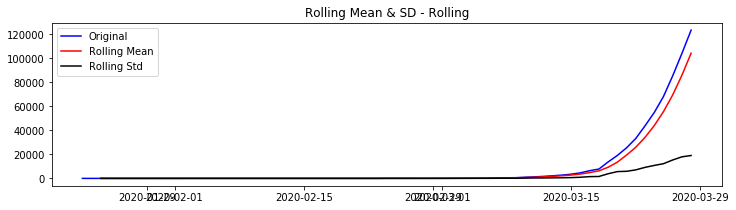

 > Is the data stationary ?
ADF Statistics = 5.0729
p-value = 1.0000
Critical Values:
	1%: -3.5552728880540942 - The data is NOT stationary with 99% confidence
	5%: -2.9157312396694217 - The data is NOT stationary with 95% confidence
	10%: -2.5956695041322315 - The data is NOT stationary with 90% confidence


In [10]:
N = 3

get_stationarity(df,N, 'Rolling')

#### 2. Subtract Rolling Mean

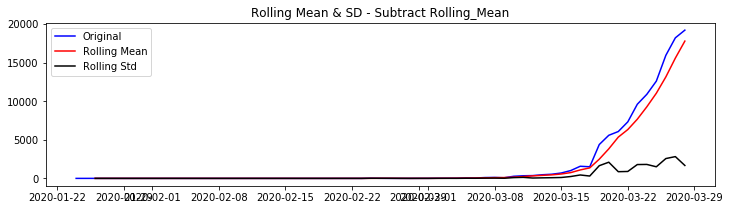

 > Is the data stationary ?
ADF Statistics = 1.4222
p-value = 0.9972
Critical Values:
	1%: -3.560242358792829 - The data is NOT stationary with 99% confidence
	5%: -2.9178502070837 - The data is NOT stationary with 95% confidence
	10%: -2.5967964150943397 - The data is NOT stationary with 90% confidence


In [11]:
rolling_mean = df.rolling(window=N).mean()
rolling_std = df.rolling(window=N).std()

df_minus_mean=df-rolling_mean
df_minus_mean.dropna(inplace=True)

get_stationarity(df_minus_mean,N, 'Subtract Rolling_Mean')

#### 3. De-Trending

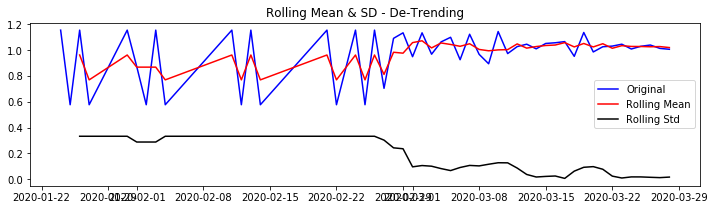

 > Is the data stationary ?
ADF Statistics = -1.5277
p-value = 0.5197
Critical Values:
	1%: -3.5812576580093696 - The data is NOT stationary with 99% confidence
	5%: -2.9267849124681518 - The data is NOT stationary with 95% confidence
	10%: -2.6015409829867675 - The data is NOT stationary with 90% confidence


In [12]:
df_DeTrending=(df-rolling_mean)/rolling_std
df_DeTrending.dropna(inplace=True)

get_stationarity(df_DeTrending,N, 'De-Trending')

#### 4. Differencing

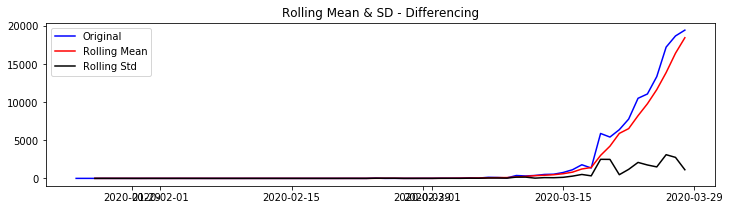

 > Is the data stationary ?
ADF Statistics = 0.2086
p-value = 0.9727
Critical Values:
	1%: -3.55770911573439 - The data is NOT stationary with 99% confidence
	5%: -2.9167703434435808 - The data is NOT stationary with 95% confidence
	10%: -2.59622219478738 - The data is NOT stationary with 90% confidence


In [13]:
df_differencing=df-df.shift(1)      # same as df.diff(1)

df_differencing.dropna(inplace=True)

get_stationarity(df_differencing,N, 'Differencing')

The rolling mean and rolling std increase with time. So the time series is NOT stationary

All ADF Statistics are far from critical values (if the ADF test is positive, automatically decided NOT to reject the NULL hypothesis), and the p-values are greater than the threshold(0.05)

Conclusion: the time series are NOT stationary

## Apply transformation to render it stationary
### Log the data to lower increasing

Taking the log of the dependent variable is simple way of lowering the rate at which rolling mean increase
1. Log
2. Subtract Rolling Mean
3. Exponential decay
4. Differencing

#### 1. Log

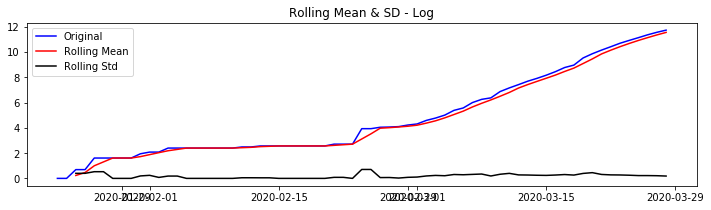

 > Is the data stationary ?
ADF Statistics = 1.9748
p-value = 0.9986
Critical Values:
	1%: -3.5335601309235605 - The data is NOT stationary with 99% confidence
	5%: -2.9064436883991434 - The data is NOT stationary with 95% confidence
	10%: -2.590723948576676 - The data is NOT stationary with 90% confidence


In [14]:
df_log = np.log(df)

get_stationarity(df_log,N, 'Log')

#### 2. Subtract Rolling Mean

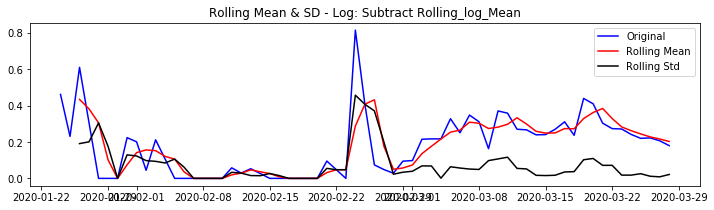

 > Is the data stationary ?
ADF Statistics = -4.5699
p-value = 0.0001
Critical Values:
	1%: -3.53692771987915 - The data is  stationary with 99% confidence
	5%: -2.907887369384766 - The data is  stationary with 95% confidence
	10%: -2.591493291015625 - The data is  stationary with 90% confidence


In [15]:
rolling_log_mean = df_log.rolling(window=N).mean()
rolling_log_std = df_log.rolling(window=N).std() # have value 0

df_log_minus_mean=df_log-rolling_log_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean,N, 'Log: Subtract Rolling_log_Mean')

###### After subtraction the mean, the rolling mean and standard deviation are approximately parallel and horizontial (?). The p-value is below the threshold of 0.01, and the ADF statistics is close to the critical values. Therefore, the time series is stationary. 

#### 3. Exponential decay

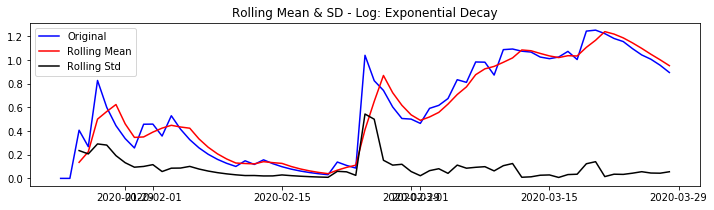

 > Is the data stationary ?
ADF Statistics = -1.9650
p-value = 0.3021
Critical Values:
	1%: -3.5335601309235605 - The data is NOT stationary with 99% confidence
	5%: -2.9064436883991434 - The data is NOT stationary with 95% confidence
	10%: -2.590723948576676 - The data is NOT stationary with 90% confidence


In [16]:
rolling_mean_exp_decay = df_log.ewm(halflife=N, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)

get_stationarity(df_log_exp_decay,N,'Log: Exponential Decay')

#### 4. Differencing

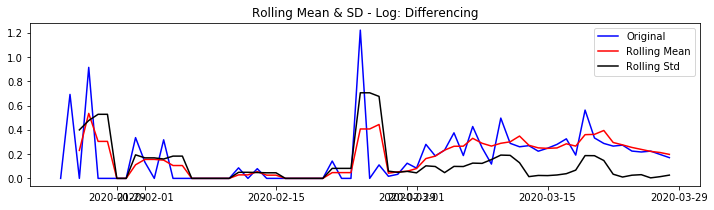

 > Is the data stationary ?
ADF Statistics = -3.1963
p-value = 0.0202
Critical Values:
	1%: -3.5386953618719676 - The data is NOT stationary with 99% confidence
	5%: -2.9086446751210775 - The data is  stationary with 95% confidence
	10%: -2.591896782564878 - The data is  stationary with 90% confidence


In [17]:
df_log_shift = df_log-df_log.shift(1) # same as df_log.diff(1)
df_log_shift.dropna(inplace = True)

get_stationarity(df_log_shift,N,'Log: Differencing')

##### The shifting performed worse than subtracting the rolling mean. However it is still more stationary than the original.

## ARIMA (aka Box-Jenkins)

Three integers (p, d, q) are typically used to parametrize ARIMA models.

p: number of autoregressive terms (AR order)

d: number of nonseasonal differences (differencing order)

q: number of moving-average terms (MA order)

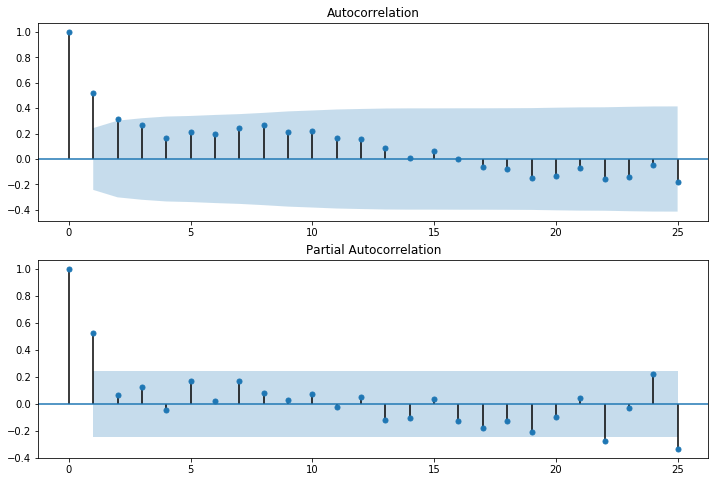

In [18]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_log_minus_mean.values.squeeze(),
                              lags = 25, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_log_minus_mean.values.squeeze(),
                               lags = 25, ax = ax2)
# plt.savefig('ARIMA/ACFandPACF_USA.pdf')
plt.show()

### 1. Choosing the differencing order
— Rule 1 : If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing. 

— Rule 2 : If the lag-1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of differencing. If the lag-1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.

(Robert Nau, Statistical Forecasting)

                              ARMA Model Results                              
Dep. Variable:              confirmed   No. Observations:                   65
Model:                     ARMA(0, 0)   Log Likelihood                  24.130
Method:                           css   S.D. of innovations              0.167
Date:                Sun, 07 Jun 2020   AIC                            -44.260
Time:                        13:08:15   BIC                            -39.911
Sample:                    01-24-2020   HQIC                           -42.544
                         - 03-28-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1795      0.021      8.669      0.000       0.139       0.220
                             ARIMA Model Results                              
Dep. Variable:            D.confirmed   No. Observat

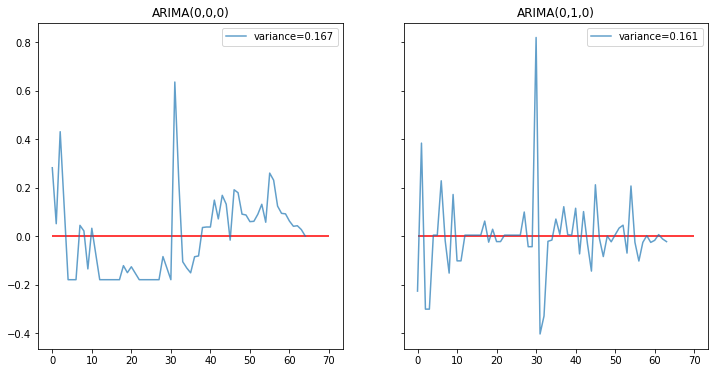

In [19]:
model = ARIMA(df_log_minus_mean.dropna(), (0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df_log_minus_mean.dropna(), (0, 1, 0))
res_010 = model.fit()
print(res_010.summary())


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=70, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=70, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

#### Check results by comparing a (0,0,0) and a( 0, 1, 0) ARIMA model

ARIMA(0,1,0) has lowered both the AIC and variance, meaning this model is performing better than the ARIMA(0,0,0)

### 2. Choosing the MA order
If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1

usually not recommended to go beyond 2

### 3. Choosing the AR order
If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.

### 4. Choosing the best parameters 

                              ARMA Model Results                              
Dep. Variable:              confirmed   No. Observations:                   65
Model:                     ARMA(0, 1)   Log Likelihood                  33.211
Method:                       css-mle   S.D. of innovations              0.145
Date:                Sun, 07 Jun 2020   AIC                            -60.421
Time:                        13:08:20   BIC                            -53.898
Sample:                    01-24-2020   HQIC                           -57.847
                         - 03-28-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1824      0.028      6.581      0.000       0.128       0.237
ma.L1.confirmed     0.5513      0.124      4.430      0.000       0.307       0.795
                                

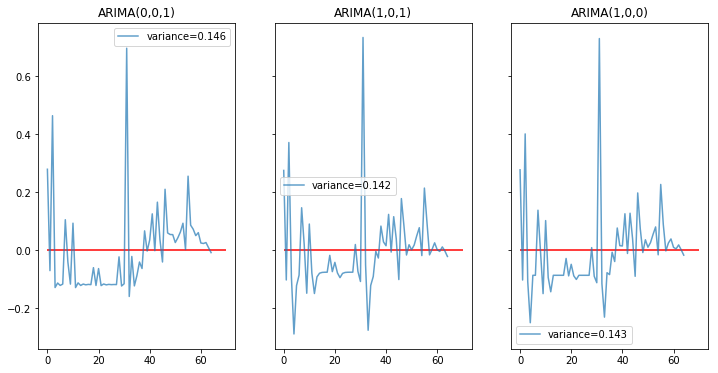

In [20]:
model = ARIMA(df_log_minus_mean.dropna(), (0, 0, 1))
res_001 = model.fit()
print(res_001.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 0, 1))
res_101 = model.fit()
print(res_101.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 0, 0))
res_100 = model.fit()
print(res_100.summary())



fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax[0].plot(res_001.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_001.resid.values)));
ax[0].hlines(0, xmin=0, xmax=70, color='r');
ax[0].set_title("ARIMA(0,0,1)");
ax[0].legend();
ax[1].plot(res_101.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_101.resid.values)));
ax[1].hlines(0, xmin=0, xmax=70, color='r');
ax[1].set_title("ARIMA(1,0,1)");
ax[1].legend();
ax[2].plot(res_100.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_100.resid.values)));
ax[2].hlines(0, xmin=0, xmax=70, color='r');
ax[2].set_title("ARIMA(1,0,0)");
ax[2].legend();

                             ARIMA Model Results                              
Dep. Variable:            D.confirmed   No. Observations:                   64
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  31.662
Method:                       css-mle   S.D. of innovations              0.147
Date:                Sun, 07 Jun 2020   AIC                            -57.324
Time:                        13:08:27   BIC                            -50.848
Sample:                    01-25-2020   HQIC                           -54.773
                         - 03-28-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0024      0.007     -0.324      0.747      -0.017       0.012
ma.L1.D.confirmed    -0.6157      0.153     -4.024      0.000      -0.916      -0.316
                        

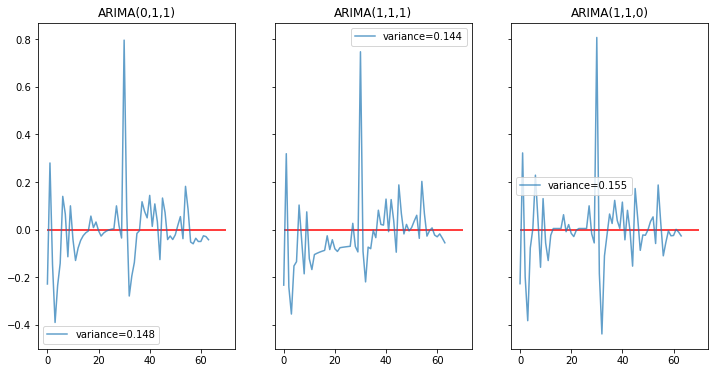

In [21]:
model = ARIMA(df_log_minus_mean.dropna(), (0, 1, 1))
res_011 = model.fit()
print(res_011.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 1, 1))
res_111 = model.fit()
print(res_111.summary())

model = ARIMA(df_log_minus_mean.dropna(), (1, 1, 0))
res_110 = model.fit()
print(res_110.summary())



fig, ax = plt.subplots(1, 3, sharey=True, figsize=(12, 6))
ax[0].plot(res_011.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_011.resid.values)));
ax[0].hlines(0, xmin=0, xmax=70, color='r');
ax[0].set_title("ARIMA(0,1,1)");
ax[0].legend();
ax[1].plot(res_111.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_111.resid.values)));
ax[1].hlines(0, xmin=0, xmax=70, color='r');
ax[1].set_title("ARIMA(1,1,1)");
ax[1].legend();
ax[2].plot(res_110.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_110.resid.values)));
ax[2].hlines(0, xmin=0, xmax=70, color='r');
ax[2].set_title("ARIMA(1,1,0)");
ax[2].legend();

##### The ARIMA(1,0,0) has the lowest AIC and second lowest variance.

### Conclusion: choose ARIMA(1,0,0) on log_minus_mean as final model

In [22]:
model = ARIMA(df_log_minus_mean.dropna(), order = (1,0,0))
results_mean = model.fit(disp = -1)

#### Plot Fitted Values

In [23]:
# have same index
RMSE = np.sqrt(sum((df_log_minus_mean.ix[results_mean.fittedvalues.index,0]-results_mean.fittedvalues)**2)/results_mean.fittedvalues.size)
print('RMSE: %.4f'% RMSE)

# convert Series file to Data Frame
a =results_mean.fittedvalues.to_frame()
a.rename(columns={0:'confirmed'}, inplace=True)

trace1 = go.Scatter(y = a['confirmed'],x = a.index,mode = 'lines',name = 'MRIMA')
trace0 = go.Scatter(y = df_log_minus_mean['confirmed'],x = df_log_minus_mean.index,mode = 'lines',name = 'df_log_minus_mean')
data = [trace0, trace1]
layout = dict(
    title = 'MRIMA Fitted Values _ USA' +'<br>'+'RMSE: %.4f'% RMSE, 
    xaxis=dict(
        title= dict(text = 'Data',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 4),
        automargin=True)
)
fig = go.Figure(data, layout)
off.iplot(fig)
# fig.write_html('Plots/ARIMA_fittedValues.html')    # save as html file
# fig.write_image('Plots/ARIMA_fittedValues.pdf')    # save as image file

RMSE: 0.1426


### Compare model with original time series

In [24]:
predictions_ARIMA_diff = pd.Series(results_mean.fittedvalues, copy = True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
Predictions_ARIMA_log = pd.Series(df_log['confirmed'].iloc[0], index = predictions_ARIMA_diff_cumsum.index)
Predictions_ARIMA_log = Predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
Predictions_ARIMA = np.exp(Predictions_ARIMA_log)

RMSE = np.sqrt(sum((df.ix[predictions_ARIMA_diff_cumsum.index,0]-Predictions_ARIMA)**2)/Predictions_ARIMA.size)
print('RMSE: %.4f'% RMSE)

# convert Series file to Data Frame
aa =Predictions_ARIMA.to_frame()
aa.rename(columns={0:'confirmed'}, inplace=True)

trace0 = go.Scatter(y = df['confirmed'],x = df.index, mode = 'lines, markers',name = 'Original Cases')
trace1 = go.Scatter(y = aa['confirmed'],x = aa.index,mode = 'lines, markers',name = 'Predicted Cases')

data = [trace0, trace1]
layout = dict(
    title = 'Comparson Between Original and Predicted Cases of USA'+'<br>'+'RMSE: %.4f'% RMSE, 
    xaxis=dict(
        title= dict(text = 'Data',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 4),
        automargin=True)
)

fig = go.Figure(data, layout)
off.iplot(fig)
# fig.write_html('Plots/ComparisonOriginalandPredicted.html')    # save as html file
# fig.write_image('Plots/ComparisonOriginalandPredicted.pdf')    # save as image file

RMSE: 2476.6524


## Check Residual

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

3. The residuals have constant variance.
4. The residuals are normally distributed.

### 1. check if residuals are uncorrelated

##### The lack of correlation suggesting the forecasts are good

###### a.  Plots visualization

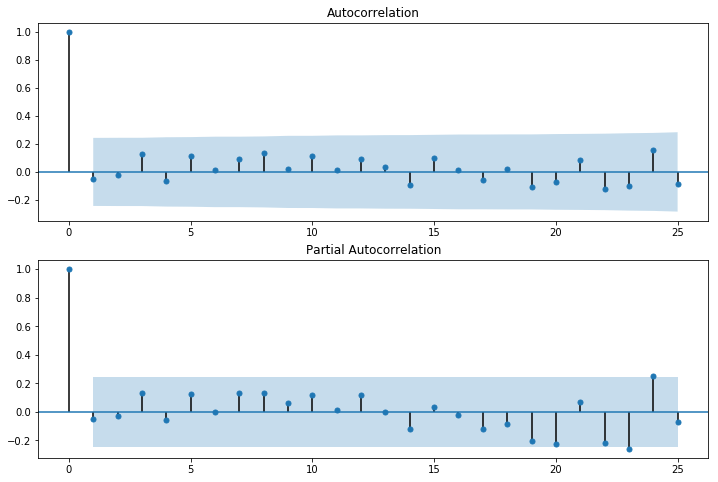

In [25]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results_mean.resid.values.squeeze(),
                              lags = 25, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results_mean.resid.values.squeeze(),
                               lags = 25, ax = ax2)
# plt.savefig('ARIMA/ACF and PACF _residual_USA.pdf')
plt.show()

###### b. Using Durbin-Watson 

Using Durbin-Watson (only for first order diffferencing  ??)

0<= DW<= 4 DW = 0 => p = 1 positive autocorrelation

DW = 4 => p =-1 negative autocorrelation

DW = 2 => p = 0 no autocorrelation

Durbin Watson Statistic Definition By WILL KENTON Updated Jul 18, 2019 What Is the Durbin Watson Statistic? The Durbin Watson (DW) statistic is a test for autocorrelation in the residuals from a statistical regression analysis. The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no autocorrelation detected in the sample. Values from 0 to less than 2 indicate positive autocorrelation and values from from 2 to 4 indicate negative autocorrelation.

In [26]:
print(sm.stats.durbin_watson(results_mean.resid.values))

2.039689051323683


### 2. Check if residuals are normal distributed

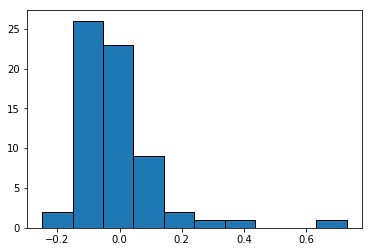

In [27]:
plt.hist(results_mean.resid.values.squeeze(), bins=10, edgecolor = 'black') 
plt.show()

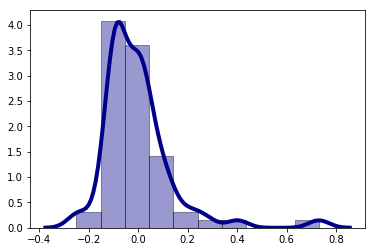

In [28]:
import seaborn as sns
# Density Plot and Histogram of all arrival delays
sns.distplot(results_mean.resid.values.squeeze(), hist=True, kde=True, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
# plt.savefig('ARIMA/Histogram_residual_USA.pdf')
plt.show()

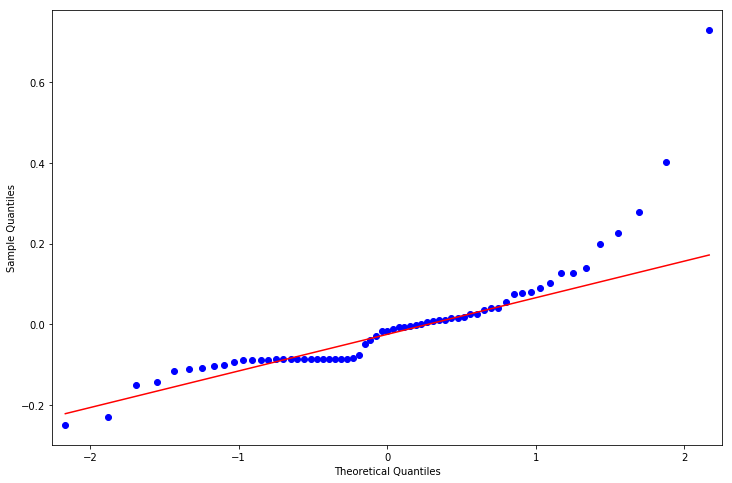

In [28]:
fig = plt.figure(figsize= (12,8))
ax1 = fig.add_subplot(111)
fig = qqplot(results_mean.resid, ax = ax1, line='q')
# plt.savefig('ARIMA/ggplot_residual_USA.pdf')
plt.show()

### 4. Check if residuals have zero mean

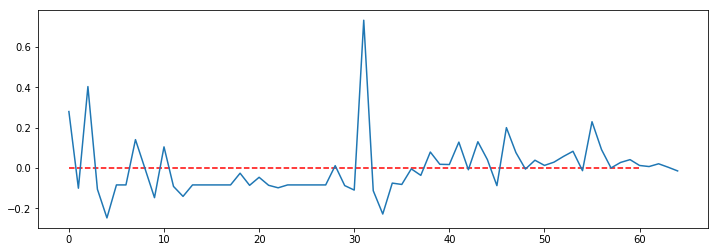

In [29]:
fig, ax = plt.subplots(figsize= (12,4))
plt.plot(results_mean.resid.values.squeeze()-results_mean.resid.values.mean())
ax.hlines(0, 0, 60, linestyle='--', color='r');
# plt.savefig('ARIMA/Residual Mean_USA.pdf')
plt.show()

## Predictions
Highly recommend to put data in a DataFrame with a DateTimeIndex, because the plot_predict() method really likes dates

### Prediction of internal sample data

Start Date of forecast:  2020-03-16


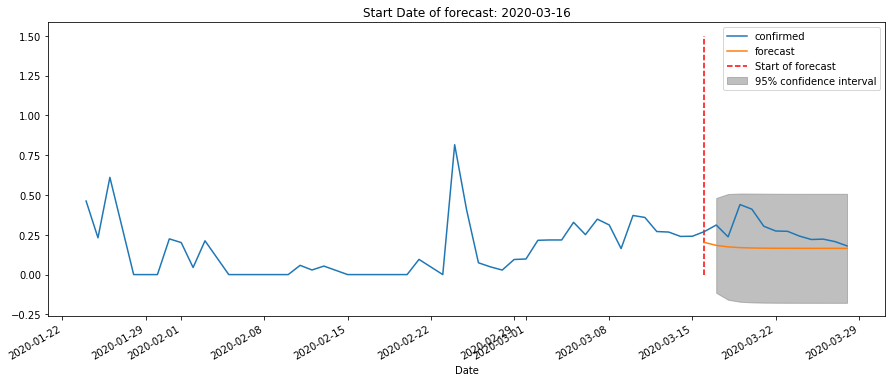

In [30]:
n = 12

model_test = ARIMA(df_log_minus_mean.dropna()[:-n], (1, 0, 0))
results_mean_test = model_test.fit()

startDate = df_log_minus_mean.dropna()[:-n].index[-1]
print('Start Date of forecast: ', startDate)
endDate=df_log_minus_mean.dropna().index[-1]

fig, ax = plt.subplots(figsize=(15, 6))
df_log_minus_mean.dropna().plot(ax=ax);
ax.vlines(startDate, 0, 1.5, linestyle='--', color='r', label='Start of forecast');
plt.title('Start Date of forecast: '+str(startDate))
ax = results_mean_test.plot_predict(start=startDate,end=endDate, dynamic=True,plot_insample=False,ax=ax)
# plt.savefig('ARIMA/Prediction_internalSample_USA.pdf')
plt.show()

### Prediction of out-of-sample data

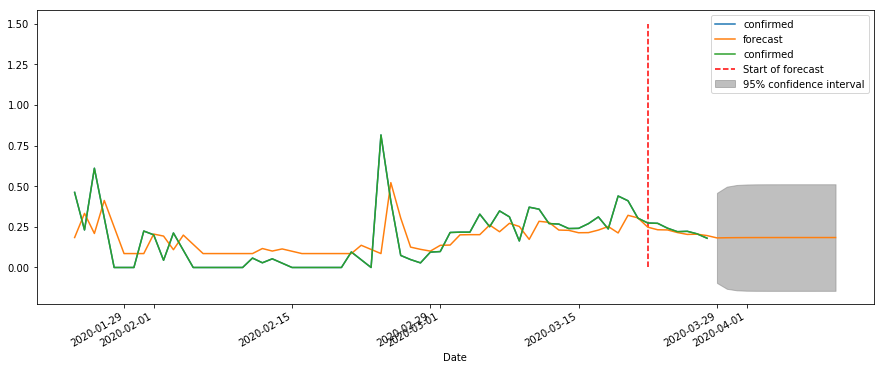

In [31]:
fig, ax = plt.subplots(figsize=(15, 6))
df_log_minus_mean.dropna().plot(ax=ax);

ax.vlines('2020, 3, 22', 0, 1.5, linestyle='--', color='r', label='Start of forecast');
ax = results_mean.plot_predict(start=results_mean.fittedvalues.index[0],end='2020, 4, 10', ax=ax)
# plt.savefig('ARIMA/Prediction_outOfSample_USA.pdf')
plt.show()

## Convert prediction back to original scale

In [32]:
prediction_mean=results_mean.predict(start='2020, 1, 24',end='2020, 4, 1')
predictions_ARIMA_diff = pd.Series(prediction_mean, copy = True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
Predictions_ARIMA_log = pd.Series(df_log['confirmed'].iloc[0], index = predictions_ARIMA_diff_cumsum.index)
Predictions_ARIMA_log = Predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
Predictions_ARIMA_new = np.exp(Predictions_ARIMA_log)

aa =Predictions_ARIMA_new.to_frame()
aa.rename(columns={0:'confirmed'}, inplace=True)

trace0 = go.Scatter(y = df['confirmed'],x = df.index,mode = 'markers, lines',name = 'Original Cases')
trace1 = go.Scatter(y = aa['confirmed'],x = aa.index, mode = 'markers,lines',name = 'Predicted Cases')

data = [trace0, trace1]
layout = dict(
    title = ' Future Prediction in USA'+'<br>', 
    xaxis=dict(
        title= dict(text = 'Data',font = dict(color = 'black')),
        tickangle = -45,
        tickfont=dict(size = 4),
        automargin=True)
)

fig = go.Figure(data, layout)
off.iplot(fig)
# fig.write_html('Plots/Future Prediction_USA.html')    # save as html file
# fig.write_image('Plots/Future Prediction_USA.pdf')    # save as image file